<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/08_NLP_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b753c893-e0db-5c03-a6e0-5d65d3e7efcf)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-10 02:33:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-10 02:33:21 (99.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2022-07-10 02:33:24--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-07-10 02:33:24 (129 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "<real disaster>" if target > 0 else "<not a real disaster>")
  print(f"Text\n{text}\n")
  print("---\n")

Target: 1 <real disaster>
Text
Refugio oil spill may have been costlier bigger than projected: A Plains All American Pipeline oil spill off ... http://t.co/yhmrEgAuxZ

---

Target: 0 <not a real disaster>
Text
@DatTomm the funniest part about that twitter is the feminists that try to attack it 4Head

---

Target: 0 <not a real disaster>
Text
We're #hiring! Read about our latest #job opening here: RN Nurse Shift Manager Emergency Services - Full time... - http://t.co/sNuBZA6KSC

---

Target: 0 <not a real disaster>
Text
'Left hand side of a diamond is a graveyard shift have to attack and defend'
The right handside no have to do that too you fucking idiot?

---

Target: 1 <real disaster>
Text
Must Read Forecast! Longest Streak of Triple-Digit Heat Since 2013 What happens next? http://t.co/xXOuPfy8nQ http://t.co/A3BJabHQhe

---



In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=42
)

In [11]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

In [12]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=15,
)

In [14]:
text_vectorizer.adapt(train_sentences)

In [15]:
text_vectorizer(["There's a flood in my street!"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [16]:
random_sent = random.choice(train_sentences)
print(f"Before: {random_sent}")
text_vectorizer([random_sent])

Before: http://t.co/X5YEUYLT1X Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/2UgrMd1z1n


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 1053,  778,  111,    4,  934,  307,  324,  624,   85,    1,
           0,    0,    0,    0]])>

In [17]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
len(words_in_vocab), top_5_words, bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

In [18]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=10000,
    output_dim=128,
    input_length=15
)

embedding

In [19]:
sample_embed = embedding(text_vectorizer([random.choice(train_sentences)]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04507717, -0.00224005,  0.04609852, ..., -0.0021066 ,
         -0.01035818,  0.00527591],
        [-0.00208781, -0.03749556, -0.00345282, ...,  0.0138194 ,
         -0.01691492, -0.04872792],
        [ 0.01519727,  0.03431578,  0.0308956 , ...,  0.03083606,
          0.02290509, -0.00700116],
        ...,
        [-0.03869274, -0.0020623 , -0.03526413, ..., -0.01614936,
         -0.0064258 ,  0.00880568],
        [ 0.00941544, -0.0287483 , -0.02082083, ...,  0.01440796,
         -0.0215555 , -0.03201125],
        [-0.00199705,  0.02612723, -0.04475057, ..., -0.03546182,
         -0.04071484,  0.01890669]]], dtype=float32)>

# Model 0: Baseline Model -> Sklearn Multinomial Naive Bayes using TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline Score: {baseline_score*100:.2f}%")

Baseline Score: 79.27%


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([1, 1, 1, 0, 0])

In [24]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [25]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

# Model 1: Simple Dense Model

In [26]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [27]:
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [28]:
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_1_dense")]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220710-023331
Epoch 1/5
215/215 [==============================] - 9s 10ms/step - loss: 0.6139 - accuracy: 0.6871 - val_loss: 0.5447 - val_accuracy: 0.7402
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4438 - accuracy: 0.8167 - val_loss: 0.4756 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3484 - accuracy: 0.8583 - val_loss: 0.4612 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2846 - accuracy: 0.8892 - val_loss: 0.4619 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2383 - accuracy: 0.9133 - val_loss: 0.4773 - val_accuracy: 0.7861


In [29]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.4773 - accuracy: 0.7861


[0.47732028365135193, 0.7860892415046692]

In [30]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[3.92267168e-01],
       [7.66281784e-01],
       [9.97199655e-01],
       [1.20908521e-01],
       [1.19712032e-01],
       [9.32403624e-01],
       [9.15031791e-01],
       [9.93441701e-01],
       [9.66001928e-01],
       [2.65195787e-01],
       [1.44744545e-01],
       [6.64626300e-01],
       [5.26842140e-02],
       [2.33492851e-01],
       [4.73433267e-03],
       [1.36542633e-01],
       [2.54899226e-02],
       [1.11467250e-01],
       [2.24613160e-01],
       [5.44249594e-01],
       [9.11829889e-01],
       [3.77721153e-02],
       [4.45430219e-01],
       [7.28433505e-02],
       [9.60463107e-01],
       [9.98732626e-01],
       [3.35952565e-02],
       [6.52277842e-02],
       [2.67753415e-02],
       [2.20202699e-01],
       [5.45319438e-01],
       [2.58246005e-01],
       [4.95796561e-01],
       [1.98807135e-01],
       [4.86732066e-01],
       [6.14924692e-02],
       [9.93698180e-01],
       [1.39636755e-01],
       [3.35295610e-02],
       [9.98640001e-01],


In [31]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [32]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results, baseline_results

({'accuracy': 78.60892388451444,
  'f1': 0.7830068921982195,
  'precision': 0.7911704681403405,
  'recall': 0.7860892388451444},
 {'accuracy': 79.26509186351706,
  'f1': 0.7862189758049549,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706})

In [33]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

# Model 2: LSTM Model

In [34]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [35]:
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [36]:
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220710-023349
Epoch 1/5
215/215 [==============================] - 9s 11ms/step - loss: 0.2250 - accuracy: 0.9237 - val_loss: 0.5034 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1606 - accuracy: 0.9412 - val_loss: 0.6924 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1326 - accuracy: 0.9502 - val_loss: 0.7258 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1080 - accuracy: 0.9577 - val_loss: 0.7744 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0876 - accuracy: 0.9666 - val_loss: 0.8440 - val_accuracy: 0.7717


In [37]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[5.7971990e-01],
       [8.1903154e-01],
       [9.9990642e-01],
       [1.6937876e-01],
       [4.0205705e-04],
       [9.9737418e-01],
       [9.6084231e-01],
       [9.9993551e-01],
       [9.9987161e-01],
       [7.9127127e-01]], dtype=float32)

In [38]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [39]:
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
model_2_results

{'accuracy': 77.16535433070865,
 'f1': 0.7715424922012581,
 'precision': 0.7714741503256236,
 'recall': 0.7716535433070866}

# Model 3: GRU Model

In [40]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [41]:
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [42]:
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_GRU")]
)

Saving TensorBoard log files to: model_logs/model_2_GRU/20220710-023406
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1627 - accuracy: 0.9362 - val_loss: 0.7079 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0855 - accuracy: 0.9675 - val_loss: 0.7287 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0671 - accuracy: 0.9737 - val_loss: 1.0799 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0560 - accuracy: 0.9742 - val_loss: 1.1787 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0517 - accuracy: 0.9768 - val_loss: 1.3392 - val_accuracy: 0.7717


In [43]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[7.3564490e-03],
       [7.2834033e-01],
       [9.9997258e-01],
       [7.9212770e-02],
       [7.6463848e-06],
       [9.9959654e-01],
       [8.8300991e-01],
       [9.9998546e-01],
       [9.9998009e-01],
       [8.2490814e-01]], dtype=float32)

In [44]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [45]:
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'f1': 0.7682834985355502,
 'precision': 0.7762974910710267,
 'recall': 0.7716535433070866}

In [46]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Model 4: Bi-Directional RNN Model

In [47]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [48]:
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [49]:
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_GRU")]
)

Saving TensorBoard log files to: model_logs/model_4_GRU/20220710-023419
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1060 - accuracy: 0.9682 - val_loss: 1.3324 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0516 - accuracy: 0.9777 - val_loss: 1.2652 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0506 - accuracy: 0.9772 - val_loss: 1.3932 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0408 - accuracy: 0.9796 - val_loss: 1.6697 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0414 - accuracy: 0.9803 - val_loss: 1.8700 - val_accuracy: 0.7677


In [50]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[9.9437898e-01],
       [9.4117332e-01],
       [9.9999928e-01],
       [2.8882724e-01],
       [8.0536302e-07],
       [9.9999869e-01],
       [9.9984157e-01],
       [1.0000000e+00],
       [9.9999976e-01],
       [9.9986887e-01]], dtype=float32)

In [51]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [52]:
model_4_results = calculate_results(y_true=val_labels, y_pred=model_4_preds)
model_4_results

{'accuracy': 76.77165354330708,
 'f1': 0.766597011860758,
 'precision': 0.7677367335034279,
 'recall': 0.7677165354330708}

# Model 5: Conv1D Model

In [53]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [54]:
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 1)              

In [55]:
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=10,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")]
)

Saving TensorBoard log files to: model_logs/Conv1D/20220710-023433
Epoch 1/10
215/215 [==============================] - 9s 6ms/step - loss: 0.1254 - accuracy: 0.9584 - val_loss: 0.9001 - val_accuracy: 0.7717
Epoch 2/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0779 - accuracy: 0.9712 - val_loss: 1.0302 - val_accuracy: 0.7703
Epoch 3/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0621 - accuracy: 0.9756 - val_loss: 1.1520 - val_accuracy: 0.7572
Epoch 4/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0568 - accuracy: 0.9766 - val_loss: 1.1758 - val_accuracy: 0.7664
Epoch 5/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0506 - accuracy: 0.9788 - val_loss: 1.2466 - val_accuracy: 0.7625
Epoch 6/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9781 - val_loss: 1.2610 - val_accuracy: 0.7585
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0493 

In [56]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[4.4066703e-01],
       [9.5935845e-01],
       [9.9996948e-01],
       [3.3706084e-02],
       [8.6167404e-07],
       [9.9659133e-01],
       [9.2171019e-01],
       [9.9999332e-01],
       [9.9999905e-01],
       [8.5726804e-01]], dtype=float32)

In [57]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [58]:
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'f1': 0.758116023760764,
 'precision': 0.7604578907479682,
 'recall': 0.7598425196850394}

# Model 6: Transfer Learning -> Universal Sentence Encoder

In [59]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, name="USE")

model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="relu")
], name="model_6_USE")

model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_USE")]
)

model_6.summary()

Saving TensorBoard log files to: model_logs/model_6_USE/20220710-023514
Epoch 1/5
215/215 [==============================] - 6s 13ms/step - loss: 0.5797 - accuracy: 0.7348 - val_loss: 0.5124 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4597 - accuracy: 0.8121 - val_loss: 0.5002 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4428 - accuracy: 0.8095 - val_loss: 0.4742 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.6213 - accuracy: 0.7269 - val_loss: 0.5177 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4543 - accuracy: 0.8025 - val_loss: 0.5205 - val_accuracy: 0.7940
Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 

In [60]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.29445696],
       [0.767015  ],
       [1.0076684 ],
       [0.2106513 ],
       [0.61790484],
       [0.7452192 ],
       [1.0460303 ],
       [1.1675125 ],
       [0.6497609 ],
       [0.11287041]], dtype=float32)

In [61]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [62]:
model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_preds)
model_6_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 79.26509186351706,
 'f1': 0.791619512726746,
 'precision': 0.7949799848167683,
 'recall': 0.7926509186351706}

# Model 7: Transfer Learning with 10% of the dataset

In [63]:
## THIS CELL IS WRONG
# data leakage happens here because train_test_split overlaps with this line
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [64]:
# THIS CELL TAKES FROM THE TRAIN_SENTENCES SO NO "DOUBLE DIPPING" OCCURS
train_sentences_10_percent = train_sentences[:int(0.1 * len(train_sentences))]
train_labels_10_percent = train_labels[:int(0.1 * len(train_sentences))]

In [65]:
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [66]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [67]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_7_history = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_of_the_data")]
)

Saving TensorBoard log files to: model_logs/10_percent_of_the_data/20220710-023541
Epoch 1/5
22/22 [==============================] - 3s 44ms/step - loss: 1.0919 - accuracy: 0.5942 - val_loss: 0.6525 - val_accuracy: 0.5748
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5464 - accuracy: 0.7387 - val_loss: 0.5522 - val_accuracy: 0.7585
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4821 - accuracy: 0.8234 - val_loss: 0.5094 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4335 - accuracy: 0.8336 - val_loss: 0.4952 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.3953 - accuracy: 0.8453 - val_loss: 0.5788 - val_accuracy: 0.7808


In [68]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.27473193],
       [0.59915656],
       [1.0273225 ],
       [0.06112904],
       [0.53526443],
       [0.65454745],
       [0.9887165 ],
       [0.82311845],
       [0.9321787 ],
       [0.10010032]], dtype=float32)

In [69]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [70]:
model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'f1': 0.778533312750939,
 'precision': 0.7834583238190046,
 'recall': 0.7808398950131233}

# Comparing Models

In [71]:
all_model_results = pd.DataFrame({
    "0_baseline": baseline_results,
    "1_dense": model_1_results,
    "2_LSTM": model_2_results,
    "3_GRU": model_3_results,
    "4_Bi-directional": model_4_results,
    "5_conv1d": model_5_results,
    "6_USE": model_6_results,
    "7_USE_10_percent": model_7_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_dense,78.608924,0.791170,0.786089,0.783007
2_LSTM,77.165354,0.771474,0.771654,0.771542
3_GRU,77.165354,0.776297,0.771654,0.768283
4_Bi-directional,76.771654,0.767737,0.767717,0.766597
5_conv1d,75.984252,0.760458,0.759843,0.758116
6_USE,79.265092,0.794980,0.792651,0.791620
7_USE_10_percent,78.083990,0.783458,0.780840,0.778533


In [72]:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_dense,0.786089,0.791170,0.786089,0.783007
2_LSTM,0.771654,0.771474,0.771654,0.771542
3_GRU,0.771654,0.776297,0.771654,0.768283
4_Bi-directional,0.767717,0.767737,0.767717,0.766597
5_conv1d,0.759843,0.760458,0.759843,0.758116
6_USE,0.792651,0.794980,0.792651,0.791620
7_USE_10_percent,0.780840,0.783458,0.780840,0.778533


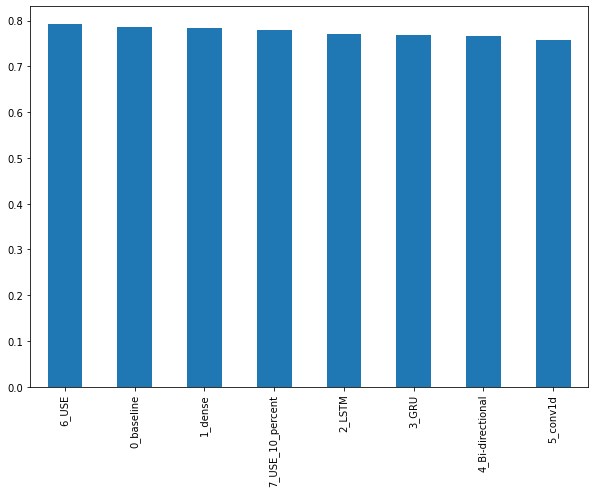

In [73]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

# Saving & Loading a Model

In [74]:
# save as h5 format
model_6.save("model_6.h5")

In [75]:
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5",
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [76]:
# save as default format (SavedModel)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [77]:
loaded_model_6 = tf.keras.models.load_model("model_6_SavedModel_format")
loaded_model_6

# Finding the most wrong examples


In [78]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-07-10 02:36:11--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  58.0MB/s    in 13s     

2022-07-10 02:36:25 (67.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [79]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [80]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_pretrained_preds,
    "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)
})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [82]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)

In [83]:
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [84]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [85]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Pred Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1.0, Pred Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1.0, Pred Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1.0, Pred Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1.0, Pred Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1.0, Pred Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1.0, Pred Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings a

# Predicting the test dataset

In [86]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("---\n")


Pred: 0, Prob: 0.08122701197862625
Text:
@Siren_Six @B30wu1f2 
Well then we see things differently.

---

Pred: 0, Prob: 0.17135672271251678
Text:
We The Free Hailstorm Maxi http://t.co/Cnn1nXXNwc

---

Pred: 1, Prob: 0.8956476449966431
Text:
We dont really talk about the murder of the bombing campaigns in WWII because we won but murder it is. https://t.co/jsGwnY6kdJ

---

Pred: 0, Prob: 0.4963698089122772
Text:
San Patricio ÛÓ Windstorm insurance reform key for coastal homeowners: PORTLAND ÛÒ State Rep. J.M. Lozano spoke ... http://t.co/GQySVKrAGi

---

Pred: 0, Prob: 0.06454399973154068
Text:
Drunk #BBMeg! ??????

---

Pred: 0, Prob: 0.22477395832538605
Text:
Bucket list checked 3 hours of sleep in 2 days with 3 presentations on the second day and survived ??

---

Pred: 1, Prob: 0.9370320439338684
Text:
@TheRealPBarry How much CO2 does an erupting volcano and bush fires raging put into the atmosphere? None of the believers mention this.

---

Pred: 0, Prob: 0.19616228342056274
Tex